In [1]:
# --- Install dependencies ---
%pip install torch transformers datasets peft accelerate bitsandbytes trl faiss-cpu sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# --- Load dataset ---
from datasets import load_dataset

DATA_PATH = "/kaggle/input/rafikibot/instructions_QA_cleaned.jsonl"
raw_dataset = load_dataset("json", data_files=DATA_PATH, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
# --- Split into train/validation (80/20) ---
dataset = raw_dataset.train_test_split(test_size=0.2, seed=42)
train_ds = dataset["train"]
eval_ds = dataset["test"]

print("Train size:", len(train_ds))
print("Validation size:", len(eval_ds))
print(train_ds.column_names)

Train size: 1405
Validation size: 352
['formatted']


In [6]:
# --- Parse into prompt/label ---
def parse_formatted(example):
    text = example["formatted"]
    if "Answer:" in text:
        q, a = text.split("Answer:", 1)
        q = q.replace("Question:", "").strip()
        a = a.strip()
    else:
        q, a = text, ""
    return {"prompt": f"### Question:\n{q}\n### Answer:\n", "label": a}

train_ds = train_ds.map(parse_formatted, remove_columns=["formatted"])
eval_ds = eval_ds.map(parse_formatted, remove_columns=["formatted"])

print(train_ds[0])

{'prompt': '### Question:\n### \ngood night\n###\n### Answer:\n', 'label': 'Goodbye! Wishing you peace and comfort today.'}


In [7]:
%pip install -U bitsandbytes

Note: you may need to restart the kernel to use updated packages.


In [8]:
# --- Load model ---
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

model_name = "microsoft/phi-3-mini-4k-instruct"

quant_config = BitsAndBytesConfig(load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config
)

# Apply LoRA adapters
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["qkv_proj", "o_proj", "fc1", "fc2"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)

2025-10-08 17:02:51.933264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759942972.152193      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759942972.208782      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [9]:
# --- Tokenization ---
def tokenize_function(examples):
    return tokenizer(
        [p + l for p, l in zip(examples["prompt"], examples["label"])],
        truncation=True,
        max_length=512
    )

train_tokenized = train_ds.map(tokenize_function, batched=True, remove_columns=train_ds.column_names)
eval_tokenized = eval_ds.map(tokenize_function, batched=True, remove_columns=eval_ds.column_names)

Map:   0%|          | 0/1405 [00:00<?, ? examples/s]

Map:   0%|          | 0/352 [00:00<?, ? examples/s]

/tmp/ipykernel_36/2213621474.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,2.305000
20,1.405400
30,1.273500
40,1.215500
50,1.064400
60,0.985200
70,0.975900
80,0.859300
90,0.808500
100,0.788100


{'eval_loss': 0.5804643630981445, 'eval_runtime': 21.1433, 'eval_samples_per_second': 16.648, 'eval_steps_per_second': 2.081, 'epoch': 1.0}


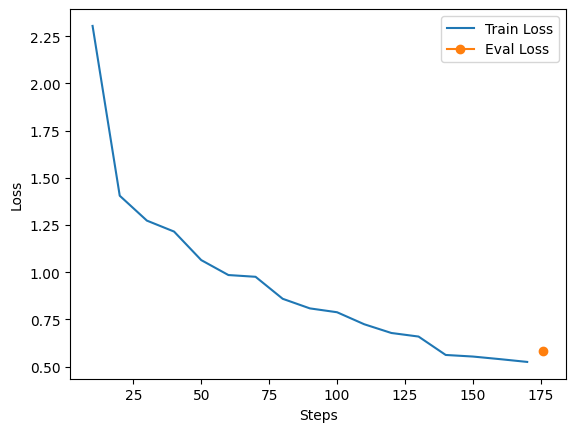

In [10]:
# --- Training ---
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
import math

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir="./rafiki-phi3",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    save_strategy="steps",
    save_steps=50,
    logging_steps=10,
    learning_rate=2e-4,
    fp16=True,
    optim="paged_adamw_32bit",
    report_to="none"
)

def compute_metrics(eval_pred):
    # Perplexity from evaluation loss
    perplexity = math.exp(eval_pred.metrics["eval_loss"])
    return {"perplexity": perplexity}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer
)

train_result = trainer.train()
metrics = trainer.evaluate()
print(metrics)

train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
        train_steps.append(log.get("step", len(train_losses)))
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        eval_steps.append(log.get("step", len(eval_losses)))

import matplotlib.pyplot as plt

plt.plot(train_steps, train_losses, label="Train Loss")
if eval_losses:
    plt.plot(eval_steps, eval_losses, label="Eval Loss", marker="o")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

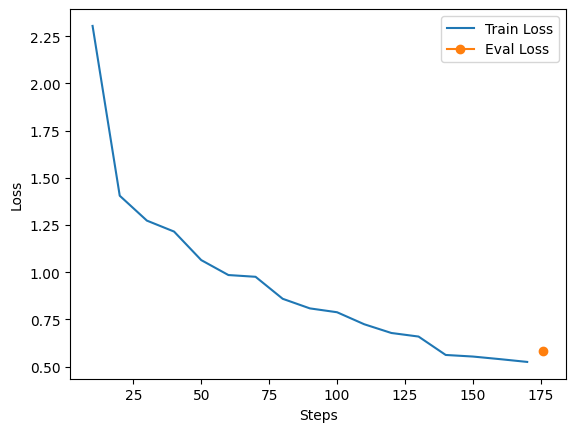

In [11]:
train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
        train_steps.append(log.get("step", len(train_losses)))
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        eval_steps.append(log.get("step", len(eval_losses)))

import matplotlib.pyplot as plt

plt.plot(train_steps, train_losses, label="Train Loss")
if eval_losses:
    plt.plot(eval_steps, eval_losses, label="Eval Loss", marker="o")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [12]:
import math

eval_results = trainer.evaluate()
perplexity = math.exp(eval_results["eval_loss"])
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 1.79


In [13]:
# --- Save model ---
trainer.save_model("./rafiki-phi3")
tokenizer.save_pretrained("./rafiki-phi3")

('./rafiki-phi3/tokenizer_config.json',
 './rafiki-phi3/special_tokens_map.json',
 './rafiki-phi3/chat_template.jinja',
 './rafiki-phi3/tokenizer.model',
 './rafiki-phi3/added_tokens.json',
 './rafiki-phi3/tokenizer.json')

In [24]:
# --- Interactive Chat with Rafiki Bot (with history) ---

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import PeftModel
import re

base_model_name = "microsoft/phi-3-mini-4k-instruct"
lora_path = "./rafiki-phi3"

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    load_in_4bit=True
)

# Attach LoRA adapters
model = PeftModel.from_pretrained(base_model, lora_path)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# Create pipeline
chatbot = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

def clean_response(text):
    """
    Remove training artifacts like ### Question:, ### Answer:, ### User: from responses
    """
    # Remove any ### tags and everything after them
    text = re.split(r'###\s*(Question|Answer|User):', text)[0].strip()
    
    # Also remove any remaining ### symbols
    text = text.split('###')[0].strip()
    
    # Clean up any trailing incomplete sentences
    if text and text[-1] not in ['.', '!', '?', ':']:
        # Find the last proper sentence ending
        last_period = text.rfind('.')
        last_exclamation = text.rfind('!')
        last_question = text.rfind('?')
        last_colon = text.rfind(':')
        
        last_end = max(last_period, last_exclamation, last_question, last_colon)
        if last_end != -1:
            text = text[:last_end + 1]
    
    return text

# Interactive loop with history
print("💬 Rafiki Bot is ready! Type 'quit' to exit.\n")

chat_history = ""

while True:
    user_input = input("You: ")
    if user_input.lower() in ["quit", "exit", "stop"]:
        print("Rafiki Bot: Goodbye 👋")
        break

    # Add user input to chat history
    chat_history += f"\n### Question:\n{user_input}\n### Answer:\n"

    # Generate response
    resp = chatbot(chat_history, max_new_tokens=128, temperature=0.7, do_sample=True)
    bot_reply = resp[0]["generated_text"]

    # Extract only the new answer (avoid repeating the whole history)
    new_reply = bot_reply[len(chat_history):].strip()

    # CLEAN THE RESPONSE - This is the key fix!
    cleaned_reply = clean_response(new_reply)

    # Add bot reply to history
    chat_history += cleaned_reply

    print("Rafiki Bot:", cleaned_reply)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


💬 Rafiki Bot is ready! Type 'quit' to exit.



You:  "My child covers their ears constantly in noisy places. What can I do?"


Rafiki Bot: Crowds or loud noises can be overwhelming. Try noise-canceling headphones, request quieter seating in school, and teach calming grounding techniques. You can also create a safe word for your child to use when overwhelmed.


You:  "He won't wear any clothes with tags - we've tried everything. Any suggestions?"


Rafiki Bot: Some children dislike tags and elastic. Try soft cotton clothes without seams or buttons. You can also label clothes with simple shapes or cut out tags yourself. Always give choices in safe materials when shopping.


You:  She only eats 3 specific foods and gags at anything new. How can I expand her diet?"


Rafiki Bot: Introduce new foods slowly alongside favorites. Use familiar utensils, serve in small bites, and model eating. Always respect preferences, but gently encourage variety for nutrition.


You:  "Bright lights really seem to bother him at school. What helps?"


Rafiki Bot: Dim lighting and sunglasses can reduce glare. Provide handouts in soft lighting and give your child a headband or cap to wear at school. You can also explore tinted glasses if needed.


You:  "He understands what we say but doesn't use words to ask for things. What works?"


Rafiki Bot: Use simple signs, pictures, or pointing to communicate needs. Model giving and taking, and reward attempts. You can also try communication apps or tools available in your region.


You:  "We had a huge meltdown at the grocery store today. How can I prevent this?"


Rafiki Bot: Create a visual checklist at home, try quieter stores, and bring favorite items to ease transitions. Remind yourself that meltdowns are stress reactions, not your child's fault. Seek support when overwhelmed.


You:  Do you think I am a bad parent for sometimes feelin ashamed about having an autistic child 


Rafiki Bot: You are not alone or at fault. Many parents feel overwhelmed. Seek support, practice self-care, and remember you are doing your best for your child. You are a caring and capable parent.


You:  Okay goodnight had a nice chat with you today actually


Rafiki Bot: I'm glad you found the chat helpful. Remember, you're not alone. Seek support, take breaks, and celebrate small wins. You are doing a great job. Goodnight, and take care.


You:  My name is Ashley btw


Rafiki Bot: Hello Ashley, I'm here to help. What can I do for you today?


You:  Who is the current president of Kenya


Rafiki Bot: The current president of Kenya is Mwai_Kariuki_Kibaki_2022.


You:  Do you know about strathmore university?


Rafiki Bot: Yes, Strathmore University is a well-known Kenyan institution. It offers various programs for students.


You:  My sister told me she doesnt like my autistic child what can I do


Rafiki Bot: It's common for family members to feel overwhelmed. Try to communicate your child's needs clearly, seek support, and educate others when possible. Remember, you are not alone.


You:  Bye now I love you


Rafiki Bot: Thank you! I'm here whenever you need support. Take care and remember to be kind to yourself. Goodnight.


KeyboardInterrupt: Interrupted by user